# Objective:

Notebook detailing the results for the following publication:

Mital, U., Ahdi, S., Herrick, J., Iwahashi, J., Savvaidis, A., Yong, A., 2021. A probabilistic framework to model distributions of Vs30. *Bull. Seism. Soc. Am* (accepted)

Author: Utkarsh Mital

In [1]:
%matplotlib inline

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import uniform
from sklearn.model_selection import KFold

from scipy.integrate import quad
from statsmodels.distributions.empirical_distribution import ECDF


import seaborn as sns
import pandas as pd

# Read raw data

Note that I have taken out the first two values, which are outliers as documented in the publication.

In [2]:
all_data = pd.read_csv("vs30_compilation_joined_Apr12.csv",encoding='latin1')
data = all_data[['VS30__M_S_','Junko2018']][2:]
Junko2018_classes = np.sort(data['Junko2018'].unique())
Junko2018_classes = Junko2018_classes[np.hstack([np.arange(3,15),np.arange(0,3)])]
Junko2018_classes = Junko2018_classes.astype(str)

print ("Junko2018 classes:", Junko2018_classes)

Junko2018 classes: ['1a' '1b' '2a' '2b' '3a' '3b' '4' '5' '6' '7' '8' '9' '10' '11' '12']


In [3]:
data

,VS30__M_S_,Junko2018
2,45.9,11
3,96.2,8
4,99.1,8
5,100.7,10
6,106.0,11
...,...,...
4126,1734.0,6
4127,1760.0,2b
4128,1817.0,9
4129,2073.0,9


# Probability distributions

In [4]:
def plot_slowness(class_name):
    
    current_Vs30 = data[data['Junko2018'] == class_name]['VS30__M_S_']
    slowness = 1./current_Vs30
    
    
    #### Compute mu and sigma as reported in Table 3
    fitted_params = norm.fit(slowness)
    mu = fitted_params[0]
    sigma = fitted_params[1]
    ###################################################
    
    ### Plot histogram and pdf for Ss30 ###############
    norm_fitted = norm(*fitted_params)
    xmin = mu - 5*sigma
    xmax = mu + 5*sigma
    lnspc = np.linspace(xmin, xmax,200);
    
    plt.hist(slowness, density=True, alpha=0.4, bins='sturges')
    plt.plot(lnspc, norm_fitted.pdf(lnspc), linewidth=3.0, color='C1')
    plt.title(''.join(['Class ' ,class_name, ': $S_{S30}$ ($n$=',str(current_Vs30.size),')']))
    plt.ylabel('Normalized Frequency')
    plt.xlabel('$S_{S30}$ (s/m)')
#     plt.savefig(''.join(['Ss30_',class_name,'.pdf']),dpi=300, bbox_inches='tight')
    plt.show()
    ####################################################
    
    
    #### Plot histogram and pdf for Vs30 ################
    x = np.linspace(1,2200,200)
    y = 1./(x**2.0 * np.sqrt(2.0*np.pi*sigma**2.0)) * np.exp(- (1./x - mu)**2 / (2.*sigma**2))
    plt.hist(current_Vs30, density=True, alpha=0.4, bins='doane')
    plt.plot(x,y, linewidth=3.0, color='C1', label='Reciprocal-normal fit')
    plt.plot(x[np.argmax(y)], y[np.argmax(y)],'ro')
    
    plt.title(''.join(['Class ' ,class_name, ': $V_{S30}$ ($n$=',str(current_Vs30.size),')']))
    plt.ylabel('Normalized Frequency')
    plt.xlabel('$V_{S30}$ (m/s)')
    plt.tick_params()
#     plt.savefig(''.join(['Vs30_',class_name,'.pdf']),dpi=300, bbox_inches='tight')
    
    #########################################################
    
    
    mode_rn = x[np.argmax(y)]
    print (f"Reciprocal-normal mode is {mode_rn} m/s")
        
    mu_h = np.round(mu,4)
    sigma_h = np.round(sigma,5)
    
    return (mu_h, sigma_h)

### Figure 13

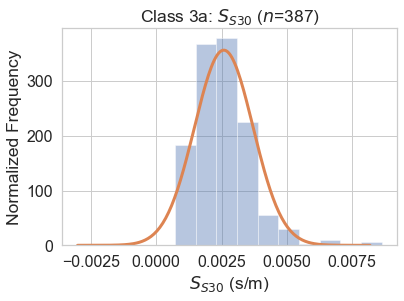

Reciprocal-normal mode is 299.356783919598 m/s


(0.0026, 0.00112)

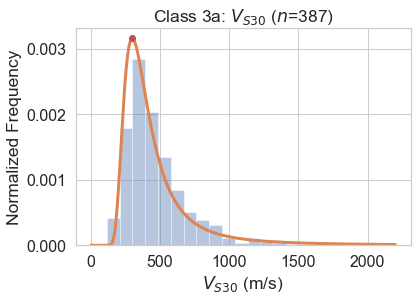

In [5]:
sns.set(font_scale=1.45, style='whitegrid')
plot_slowness('3a')

# Cumulative distributions

Plot empirical and theoretical distributions.

In [11]:

def reciprocal_integrand(x, mu, sigma):
    """ 
    Compute the reciprocal-normal distribution given a value of mu and sigma
    """
    return 1./(x**2 *np.sqrt(2.0*np.pi*sigma**2.0)) * np.exp(- (1./x - mu)**2 / (2.*sigma**2))

def plot_cdf(class_name, title=''):
    current_Vs30 = data[data['Junko2018'] == class_name]['VS30__M_S_']
    slowness = 1./current_Vs30
    
    #### Compute mu and sigma as reported in Table 3
    fitted_params = norm.fit(slowness)   #mu and sigma
    mu = fitted_params[0]
    sigma =fitted_params[1]
    ###################################################
    
    
    ### Plot empirical cdf and a normal fit for Ss30 ###############
    norm_fitted = norm(*fitted_params)
    xmin = mu - 5*sigma
    xmax = mu + 5*sigma
    lnspc = np.linspace(0.0, 0.01,200);
    
    slowness_ecdf = ECDF(slowness.values)
    plt.plot([], [], ' ', label=f"$n$={current_Vs30.size}")
    plt.plot(lnspc, slowness_ecdf(lnspc),'--', linewidth=2.0, label="Empirical", color='C0')
    plt.plot(lnspc, norm_fitted.cdf(lnspc), label="Normal fit", linewidth=3.0, color='C1', alpha=0.5)
    plt.ylabel('Cumulative Probability')
    plt.xlabel('$S_{S30}$ (s/m)')
    plt.title(f'Class {class_name}: {title}')
    plt.legend(loc=4)
#     plt.savefig(''.join(['Slowness_CDF_',str(class_name),'.pdf']), dpi=300, bbox_inches='tight')
    plt.show()
    ###################################################
    
    ### Plot empirical cdf and a reciprocal-normal fit for Vs30 ###############
    plt.figure()
    plt.plot([], [], ' ', label=f"$n$={current_Vs30.size}")
    x = np.linspace(1,2000,200)
    ecdf = ECDF(current_Vs30.values)
    plt.plot(x, ecdf(x),'--', linewidth=2.0, label="Empirical", color='C0')
    
    ###### Reciprocal-normal fit ####################################################
    I = np.asarray([quad(reciprocal_integrand,0, upper, args=(mu,sigma)) for upper in x])
    plt.plot(x, I[:,0], label="Reciprocal-Normal fit", linewidth=3.0, color='C1', alpha=0.5)
    ##################################################################################
    
    ###### Log-normal fit (Uncomment) ########################
#     shape,loc,scale = lognorm.fit(current_Vs30, loc=2)
#     fitted_params = lognorm.fit(current_Vs30) 
#     ln_fitted = lognorm(shape,loc,scale)
#     plt.plot(x, ln_fitted.cdf(x), label="Log-Normal fit", color='C2',linewidth=3.0, alpha=0.5)
    ###################################################################


    plt.ylabel('Cumulative Probability')
    plt.xlabel('$V_{S30}$ (m/s)')

    plt.title(f'Class {class_name}: {title}')
    plt.legend(loc=4)
#     plt.savefig(''.join(['Comparison_Vs30_CDF_',str(class_name),'.pdf']), dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
class_list = ['Steep mountains', 'Steep mountains', 'Moderate mountains', 'Moderate mountains',
            'Hills', 'Hills', 'Large slopes', 'Large slopes', 'Small slopes', 'Small slopes', 'Small slopes', 'Small slopes',
            'Plains', 'Plains', 'Plains']

### Example for Class 3a

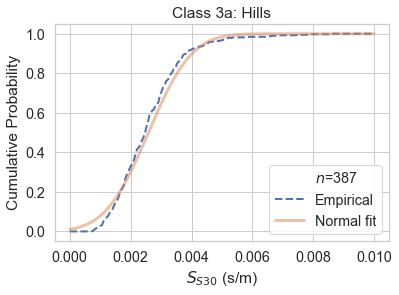

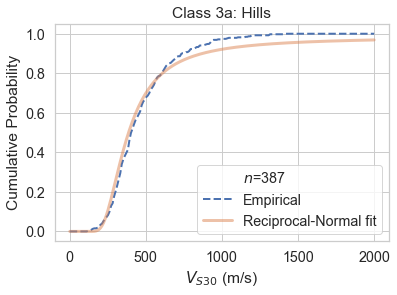

In [13]:
class_index = 4
class_name = Junko2018_classes[class_index]
sns.set(font_scale=1.3, style='whitegrid', )
# sns.set_style("whitegrid")

plot_cdf(str(class_name), class_list[class_index])

### Plot CDF for all classes (Figures 7-10)

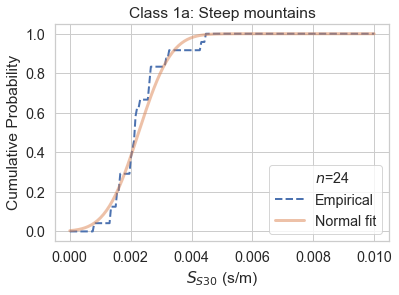

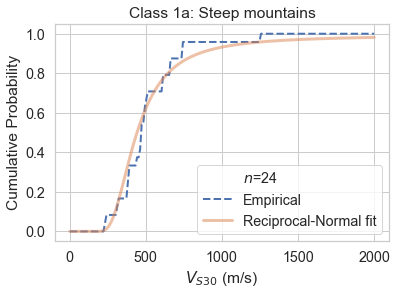

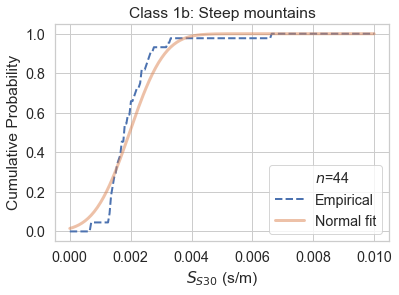

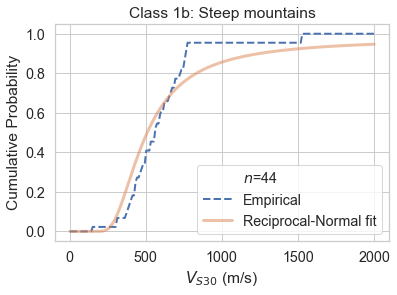

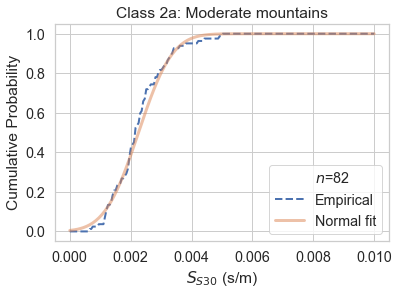

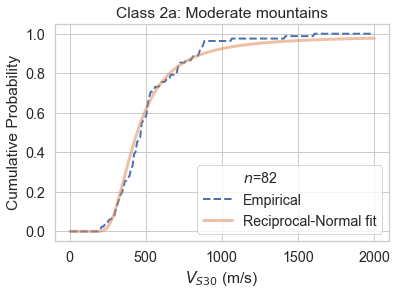

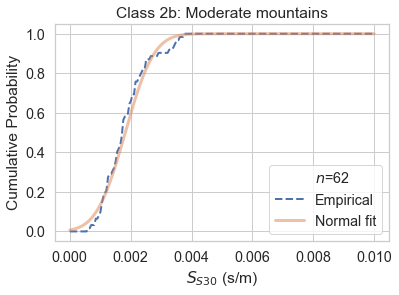

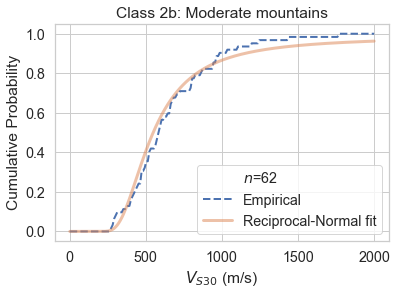

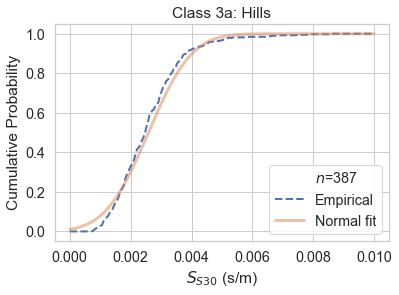

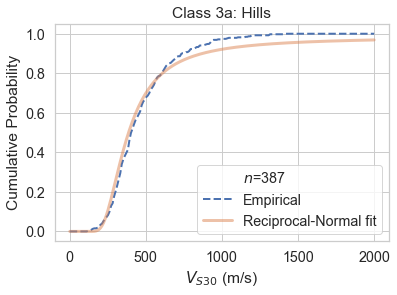

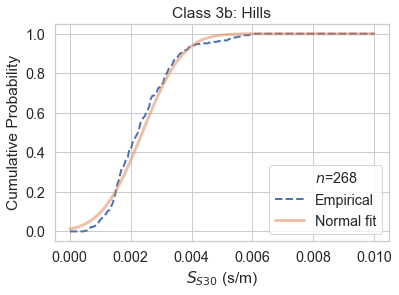

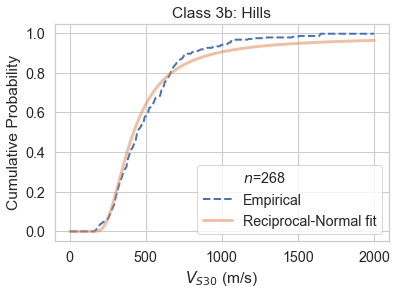

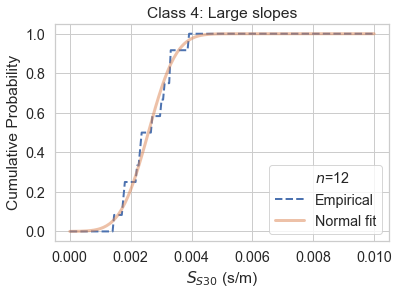

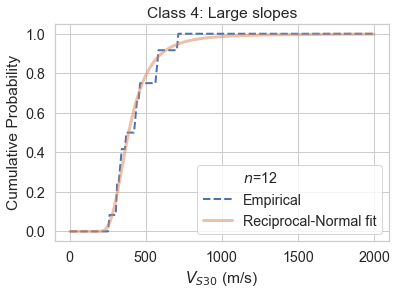

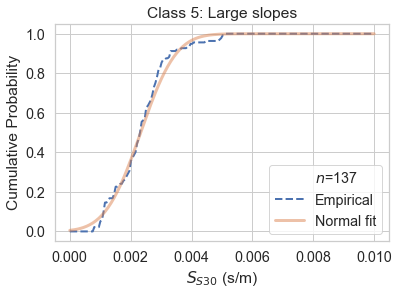

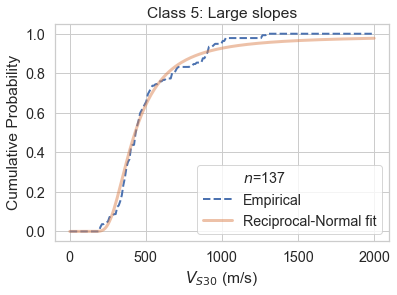

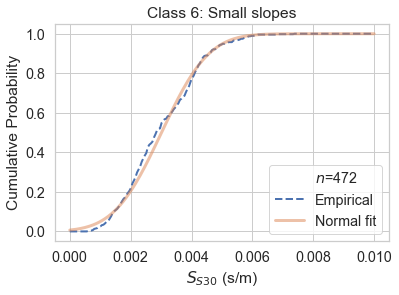

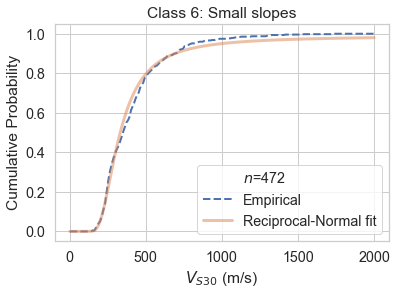

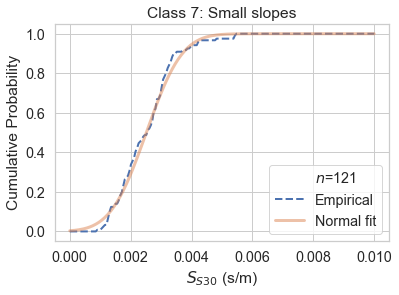

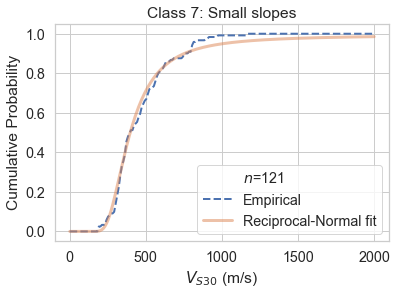

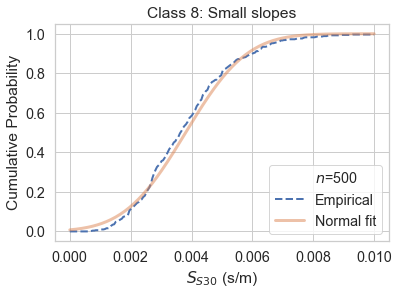

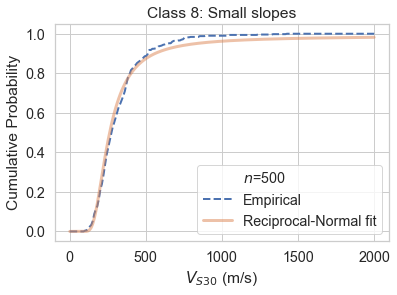

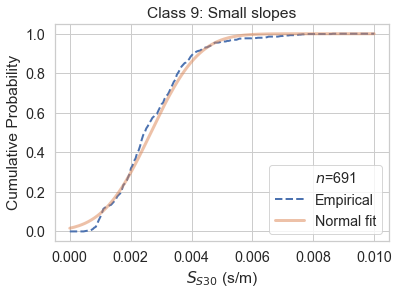

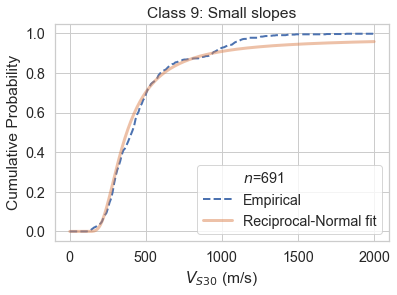

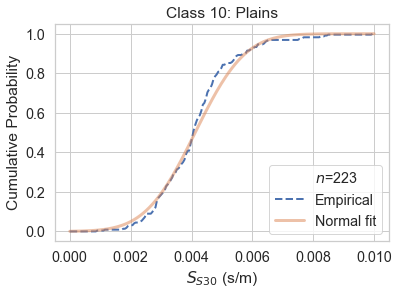

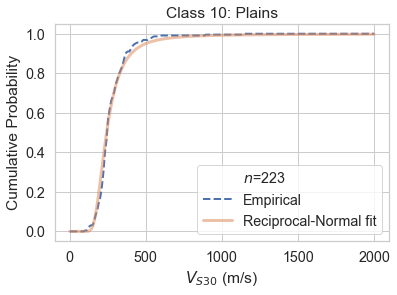

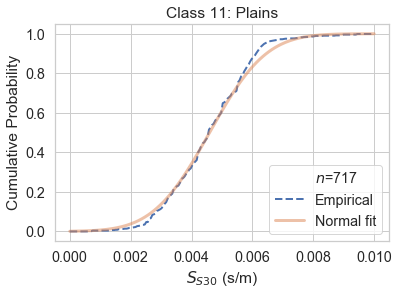

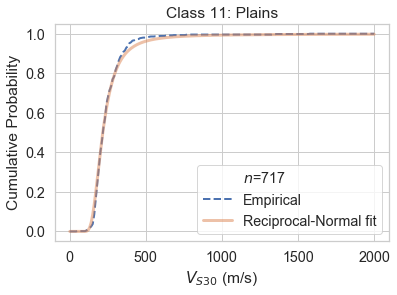

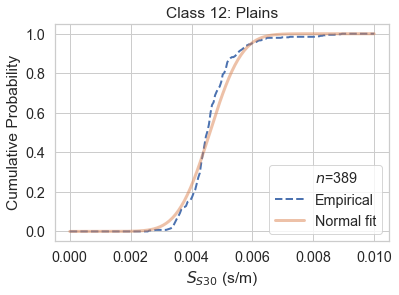

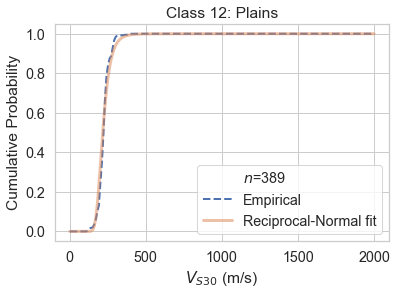

In [14]:
sns.set(font_scale=1.3, style='whitegrid')
for class_index, class_name in enumerate(Junko2018_classes):
    plot_cdf(str(class_name), class_list[class_index])

# Kolmogorov-Smirnov statistic

Quantifying misfit of reciprocal-normal and lognormal with empirical CDF

For a given cumulative distribution function $F$, we can quantify its misfit with data using the Kolmogorov-Smirnov statistic. The Kolmogorov-Smirnov statistic quantifies the distance between the empirical distribution $I$ and  reference cumulative distribution $F$.

$\max_{i} |F(x_i) - I(x_i)|$

Small value of statistic is good. p-values need to be high, but I won't consider them since I'm not doing hypothesis testing.

In [6]:
def reciprocal_integrand(x, mu, sigma):
    return 1./(x**2 *np.sqrt(2.0*np.pi*sigma**2.0)) * np.exp(- (1./x - mu)**2 / (2.*sigma**2))

class_name = '9'

current_Vs30 = data[data['Junko2018'] == class_name]['VS30__M_S_']
slowness = 1./current_Vs30
    
fitted_params = norm.fit(slowness, loc=np.mean(slowness))   #mu and sigma
mu = fitted_params[0]
sigma =fitted_params[1]


ecdf = ECDF(current_Vs30.values)


logn_fitted_params = lognorm.fit(current_Vs30, loc=np.mean(np.log(current_Vs30))) 
ln_fitted = lognorm(*logn_fitted_params)

norm_fitted_params = norm.fit(current_Vs30, loc=np.mean(current_Vs30))   #mu and sigma
norm_fitted = norm(*norm_fitted_params)

uniform_fitted_pararms = uniform.fit(current_Vs30, loc=np.min(current_Vs30), scale= np.max(current_Vs30)-np.min(current_Vs30))
uniform_fitted = uniform(*uniform_fitted_pararms)

logn_cdf = lambda x: ln_fitted.cdf(x)
recip_cdf = lambda x: np.asarray([quad(reciprocal_integrand,0, upper, args=(mu,sigma)) for upper in x])[:,0]
norm_cdf = lambda x: norm_fitted.cdf(x)
uniform_cdf = lambda x: uniform_fitted.cdf(x)


print (stats.kstest(current_Vs30, recip_cdf))
print (stats.kstest(current_Vs30, logn_cdf))
print (stats.kstest(current_Vs30, norm_cdf))
print (stats.kstest(current_Vs30, uniform_cdf))



KstestResult(statistic=0.07190907826871606, pvalue=0.0014929554065423942)
KstestResult(statistic=0.05054165964844659, pvalue=0.056602544435427705)
KstestResult(statistic=0.1675353410009931, pvalue=2.0165070623131564e-17)
KstestResult(statistic=0.5611294052224121, pvalue=1.288350440480392e-205)


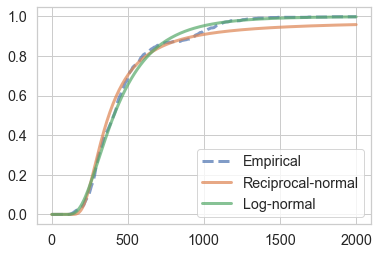

In [19]:
%matplotlib inline
x = np.linspace(1,2000,200)
plt.plot(x, ecdf(x), '--', label="Empirical", color='C0',linewidth=3.0, alpha=0.7)
plt.plot(x, recip_cdf(x), label="Reciprocal-normal", color='C1',linewidth=3.0, alpha=0.7)
plt.plot(x, logn_cdf(x), label="Log-normal", color='C2',linewidth=3.0, alpha=0.7)
# plt.plot(x, uniform_fitted.cdf(x), label="Normal", color='C4',linewidth=3.0, alpha=0.7)
plt.legend(loc=4)


# Shortest half calculations

This needs to be done serially for each class after Kolmogorov-Smirnov statistic calculations (just the way I wrote the script)

In [15]:
def get_half_interval(x, prob_array, index, cum_dist):
    lower = x[index]
    lower_cdf = cum_dist([lower])
    upper_cdf = lower_cdf + 0.5
    idx = (np.abs(prob_array - upper_cdf)).argmin()
    upper = x[idx]
    return lower, upper

In [20]:
x = np.arange(np.round(min(current_Vs30)), np.round(max(current_Vs30))+1)

#### Uncomment either reciprocal-normal (recip_cdf) or log-normal (logn_cdf) based on misfit (see Tables 4 and 5)
cum_probs = recip_cdf(x)
# cum_probs = logn_cdf(x)

In [21]:
fiftyp_index = (np.abs(cum_probs-0.5)).argmin()
halves = [get_half_interval(x, cum_probs, item, recip_cdf) for item in np.arange(fiftyp_index+1)]

lowers = [item[0] for item in halves]
uppers = [item[1] for item in halves]
interval = [item[1]-item[0] for item in halves]

min_id = np.argmin(interval)
print (f"lower value: {lowers[min_id]}, upper value: {uppers[min_id]}, shortest half: {interval[min_id]}")

lower value: 213.0, upper value: 399.0, shortest half: 186.0


# Box plots showing outliers in slowness

In [7]:
data = data.assign(Slowness = 1./data['VS30__M_S_'])

box_data = [data[data['Junko2018'] == item][['Junko2018','Slowness']] for item in Junko2018_classes]
box_df = pd.concat([item for item in box_data])

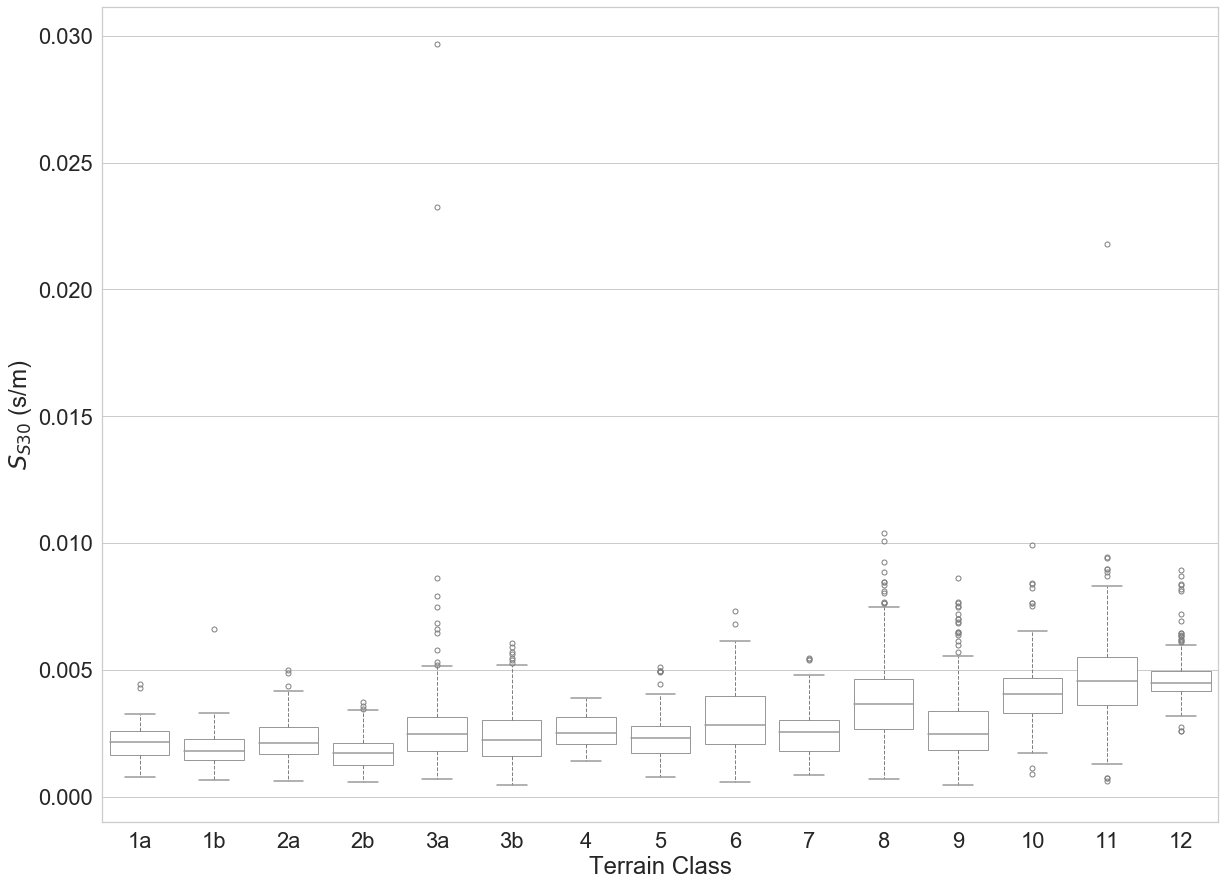

In [13]:
sns.set_style("whitegrid")
# sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20, 15))
sns.boxplot(x="Junko2018", y="Slowness", data=box_df, color = 'white',
                 whiskerprops = dict(linestyle='--',linewidth=1.0, color='gray'), 
                 boxprops = dict(linestyle='-',linewidth=1.0), 
            flierprops = dict(marker = 'o',markerfacecolor='none',markeredgecolor="gray", 
                              markeredgewidth=1))
ax.set(xlabel='Terrain Class')
sns.set(font_scale=2)
plt.ylabel('$S_{S30}$ (s/m)')

# plt.savefig('Outliers.png',dpi=300, bbox_inches='tight')
plt.show()

## Plotting all Vs30 and Ss30 data

In [33]:
data_v2 = all_data[['ID','VS30__M_S_', 'LATITUDE','LONGITUDE','Junko2018']][:]

Text(0, 0.5, 'Number of values')

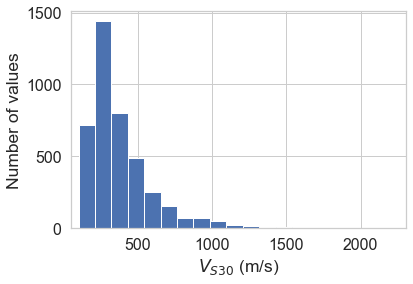

In [26]:
sns.set(font_scale=1.45, style='whitegrid')

data_v2['VS30__M_S_'].hist(bins='doane', range=(100, 2200))
plt.xlim(left=50)
plt.xlabel('$V_{S30}$ (m/s)')
plt.ylabel('Number of values')

Text(0, 0.5, 'Number of values')

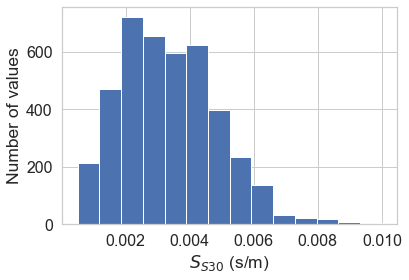

In [34]:
plt.hist(1/data_v2['VS30__M_S_'], bins='sturges', range=(0.0005,0.01))
plt.xlabel('$S_{S30}$ (s/m)')
plt.ylabel('Number of values')